# Part I: Code

In this notebook, the default nside for both beam and sky is 512.

### Sky model implementation
- GSM_maps(freqs, nside=512, beam_window): generate GSM map for given frequencies, return beam-convolved map if beam_window is not None
- SynchrotronExtropolator(): create a sky model using given spectral index map and amplitude map

Example:

    ```python
    Mel_model = SynchrotronExtrapolator()
    mel_sky_RHINO_convolved = Mel_model.map(freq_list, beam_window)
    ```

In [ ]:
import healpy as hp
import numpy as np
import glob
from pygdsm import GlobalSkyModel
import matplotlib.pyplot as plt


def smoothed_maps(maps, beam_transfer):
    """
    Smooth the maps with the given beam transfer function
    - maps: array with shape (npix, nfreq)
    - beam_transfer: array with shape (nfreq, lmax)
    Returns: 
    - smoothed_map: array with shape (npix, nfreq)
    """
    smoothed_map = np.zeros_like(maps)
    for i, bl in enumerate(beam_transfer):
        smoothed_map[:, i] = hp.smoothing(maps[:, i], beam_window=bl)
    return smoothed_map

def GSM_maps(freqs, nside=512, beam_transfer=None):
    """Generate GSM maps for multiple frequencies"""
    # Initialize GSM with parameters
    gsm = GlobalSkyModel(freq_unit='MHz')
    gsm.nside=nside
    # Generate maps for all frequencies
    maps = []
    for freq in np.atleast_1d(freqs):
        maps.append(gsm.generate(freq))
    
    # if len(maps) == 1:
    #     return maps[0]  # Return single map if only one frequency was provided
    # Stack maps along frequency axis
    maps = np.stack(maps, axis=1)  # Shape: (npix, nfreq)

    # Apply smoothing if requested
    if beam_transfer is not None:
        maps = smoothed_maps(maps, beam_transfer)

    if maps.shape[1] == 1:
        return maps.squeeze()  # Return single map if only one frequency was provided
    return maps

class SynchrotronExtrapolator:
    def __init__(self, reference_map=None, spectral_index_map=None, reference_freq=408):
        """
        Initialize with:
        - reference_map: Haslam 408 MHz map
        - spectral_index_map: the spectral index map
        - reference_freq: reference frequency in MHz (default: 408)
        """
        if reference_map is None:
            self.reference_map = hp.read_map('haslam408_dsds_Remazeilles2014.fits')
        else:
            self.reference_map = reference_map
        if spectral_index_map is None:
            self.specidx_map = np.load('cnn56arcmin_beta.npy')
        else:
            self.specidx_map = spectral_index_map
        self.ref_freq = reference_freq

    def beta_distribution(self, beam_map, n_bins=100, rotation=None, show_hist=False):
        """
        Calculate the beta distribution of the spectral index map
        - n_bins: number of bins
        - beam_map: the beam transfer function
        - rotation: optional, if provided, should be a tuple of (lon, lat, phi) in degrees; 
                    For RHINO beam, should be [target_lon, 90 + target_lat, 0], as the healpix beam is pointing towards the south pole.
        Returns:
        - hist: the histogram of the spectral index map
        - bin_edges: the bin edges of the histogram
        """
        # Get the max and min beta values
        min_beta = np.min(self.specidx_map)
        max_beta = np.max(self.specidx_map)

        # Create bins
        bins = np.linspace(min_beta, max_beta, n_bins+1)

        if rotation is not None:
            rotator = hp.Rotator(rot=rotation, deg=True)
            # Rotate the 
            weight_map = rotator.rotate_map_pixel(beam_map) * self.reference_map
        else:
            weight_map = beam_map * self.reference_map

        # Calculate the histogram
        hist, bin_edges = np.histogram(self.specidx_map, bins=bins, weights=weight_map)

        if show_hist:
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            plt.figure(figsize=(10, 6))
            plt.bar(bin_centers, hist, width=bin_edges[1]-bin_edges[0], align='center')
            plt.xlabel('Spectral Index β')
            plt.ylabel('Weighted Count')
            plt.title('Beam-weighted Spectral Index Distribution')
            plt.show()
            return

        return hist, bin_edges 
        
    def map(self, target_freqs, beam_transfer=None):
        """
        Extrapolate to target frequency/frequencies and save map(s)
        - target_freqs: scalar or 1d array/list of frequencies in MHz
        - beam_transfer: optional, if provided, should be an array with shape (nfreq, lmax)
        Returns: array with shape (npix,) for scalar input or (npix, nfreq) for array input
        """
        if self.reference_map is None or self.specidx_map is None:
            raise ValueError("Maps must be loaded before extrapolation")

        # Ensure target_freqs is an array-like
        target_freqs = np.atleast_1d(target_freqs)

        # Vectorized calculation with proper broadcasting
        scaling = (target_freqs[:, np.newaxis]/self.ref_freq) ** self.specidx_map
        extrap_maps = self.reference_map[:, np.newaxis] * scaling.T  # Shape: (npix, nfreq)

        # Apply smoothing if requested
        if beam_transfer is not None:
            return smoothed_maps(extrap_maps, beam_transfer)

        return extrap_maps if len(target_freqs) > 1 else extrap_maps.squeeze()

### Beam object implementation
Usage:
Step 1: Feed in the path to the beam (.fits) files.
Step 2: Generate the beam transfer function with the class method `generate_beam_l`

In [ ]:
class RhinoBeam:
    def __init__(self, filepath='RHINO beam/HornWet/'):
        # read and sort filenames in filepath
        self.filenames = sorted(glob.glob(filepath + '/*.fits'))
        self.nside = hp.get_nside(hp.read_map(self.filenames[0]))

    def get_beam_l(self, normalize=True):
        # Derive the beam transfer function bl as the sqrt of the power spectrum (Cl) of the beam map. 
        # This effectively take the azimuthal average of the beam map
        bl_list = []
        for filename in self.filenames:
            beam = hp.read_map(filename)
            # Compute the power spectrum (Cl) of the beam map
            cl_beam = hp.anafast(beam, lmax=3*self.nside)
            # The beam transfer function bl is the square root of Cl, normalized to bl[0]=1
            bl = np.sqrt(cl_beam)
            if normalize:
                bl /= bl[0]
            bl_list.append(bl)
        self.bl_list = bl_list

### Linear solver implementation

This is the solver for the least squares fitting of the linear system..

In [3]:

def cg(
    Amat,
    bvec,
    maxiters=1000,
    abs_tol=1e-10,
    use_norm_tol=False,
    x0=None,
    linear_op=None,
    comm=None,
):
    """
    Simple Conjugate Gradient solver that operates in serial. This uses the
    same algorithm as `cg_mpi()` and so can be used for testing/comparison of
    results.

    Note that this function will still permit threading used within numpy.

    Parameters:
        Amat (array_like):
            Linear operator matrix.
        bvec (array_like):
            Right-hand side vector.
        maxiters (int):
            Maximum number of iterations of the solver to perform before
            returning.
        abs_tol (float):
            Absolute tolerance on each element of the residual. Once this
            tolerance has been reached for all entries of the residual vector,
            the solution is considered to have converged.
        use_norm_tol (bool):
            Whether to use the tolerance on each element (as above), or an
            overall tolerance on the norm of the residual.
        x0 (array_like):
            Initial guess for the solution vector. Will be set to zero
            otherwise.
        linear_op (func):
            If specified, this function will be used to operate on vectors,
            instead of the Amat matrix. Must have call signature `func(x)`.
        comm (MPI communicator):
            If specified, the CG solver will be run only on the root worker,
            but the

    Returns:
        x (array_like):
            Solution vector for the full system.
    """
    # MPI worker ID
    myid = 0
    if comm is not None:
        myid = comm.Get_rank()

    # Use Amat as the linear operator if function not specified
    if linear_op is None:
        linear_op = lambda v: Amat @ v

    # Initialise solution vector
    if x0 is None:
        x = np.zeros_like(bvec)
    else:
        assert x0.shape == bvec.shape, "Initial guess x0 has a different shape to bvec"
        assert x0.dtype == bvec.dtype, "Initial guess x0 has a different type to bvec"
        x = x0.copy()

    # Calculate initial residual
    # NOTE: linear_op may have internal MPI calls; we assume that it
    # handles synchronising its input itself, but that only the root
    # worker receives a correct return value.

    r = bvec - linear_op(x)
    pvec = r[:]

    # Blocks indexed by i,j: y = A . x = Sum_j A_ij b_j
    niter = 0
    finished = False
    while niter < maxiters and not finished:

        try:
            if myid == 0:
                # Root worker checks for convergence
                if use_norm_tol:
                    # Check tolerance on norm of r
                    if np.linalg.norm(r) < abs_tol:
                        finished = True
                else:
                    # Check tolerance per array element
                    if np.all(np.abs(r) < abs_tol):
                        finished = True

            # Broadcast finished flag to all workers (need to use a non-immutable type)
            finished_arr = np.array(
                [
                    finished,
                ]
            )
            if comm is not None:
                comm.Bcast(finished_arr, root=0)
                finished = bool(finished_arr[0])
            if finished:
                break

            # Do CG iteration
            r_dot_r = np.dot(r.T, r)
            A_dot_p = linear_op(pvec)  # root worker will broadcast correct pvec

            # Only root worker needs to do these updates; other workers idle
            if myid == 0:
                pAp = pvec.T @ A_dot_p
                alpha = r_dot_r / pAp

                x = x + alpha * pvec
                r = r - alpha * A_dot_p

                # Update pvec
                beta = np.dot(r.T, r) / r_dot_r
                pvec = r + beta * pvec

            # Update pvec on all workers
            if comm is not None:
                comm.Bcast(pvec, root=0)
            
            # Increment iteration
            niter += 1
        except:
            raise

    if comm is not None:
        comm.barrier()

    # Synchronise solution across all workers
    if comm is not None:
        comm.Bcast(x, root=0)
    return x


### Spectral fitting (per pixel) implementation

In [2]:
import numpy as np
np.maximum(np.array([1,2,3]), 2)

array([2, 2, 3])

In [ ]:
#from scipy.sparse.linalg import cg
def linear_fit_per_pixel(data, basis, return_loss=True):
    """
    Perform linear fit for the spectrum of a single pixel.

    Parameters:
    - data: 1D array of data, shape (n_freqs,)
    - basis: 2D array of basis functions, shape (n_freqs, n_basis)
    Returns:
    - coefficients: 1D array of fit coefficients, shape (n_basis,)
    """
    A = basis
    b = data
    ATA = A.T @ A + 1e-8 * np.eye(A.shape[1]) 
    ATb = A.T @ b
    coefficients = cg(ATA, ATb)
    if return_loss:
        residuals = b - A @ coefficients
        # Calculate RMS fractional error 
        assert not np.any(np.isnan(residuals)), "NaN values detected in residuals"
        assert np.all(b > 1e-10), "b is too small to define RMS fractional error.."
        loss = np.sqrt(np.mean( (residuals / np.abs(b) ) ** 2))  # Define the loss as the root of mean squared fractional error
        return coefficients, loss

    return coefficients

def linear_model(basis, coefficients):
    """
    Compute the linear model for the spectrum of a single pixel.
    Parameters:
    - basis: 2D array of basis functions, shape (n_freqs, n_basis)
    - coefficients: 1D array of fit coefficients, shape (n_basis,)
    Returns:
    - model: 1D array of model values, shape (n_freqs,)
    """
    model = basis @ coefficients
    return model

class moment_basis:
    def __init__(self, freqs, n_moments, nu_ref=None):  # Removed trailing comma
        """Initialize spectral moment basis generator.
        
        Args:
            freqs: Array of observation frequencies [MHz]
            nu_ref: Reference frequency [MHz]
            n_moments: Number of spectral moments to model
        """
        self.n_moments = n_moments
        if nu_ref is None:
            # let xs be the centred log freqs
            self.log_nu_ref = np.log(freqs).mean()
            self.log_xs = np.log(freqs) - self.log_nu_ref
        else:
            self.log_xs = np.log(freqs / nu_ref)  # Frequency ratios ν/ν_ref

    def basis(self, beta0):
        """Generate orthogonalized spectral basis functions.
        
        Implements φ_k(ν) = (ν/ν_ref)^β₀ [ln(ν/ν_ref)]^k for k=0..n_moments-1
        
        Args:
            beta0: Reference spectral index (dimensionless)
            
        Returns:
            basis_matrix: (n_freqs, n_moments) array of basis vectors
        """
        xs_beta0 = np.exp(self.log_xs*beta0)
        
        # Use Vandermonde matrix for stable polynomial basis
        vander = np.vander(self.log_xs, N=self.n_moments, increasing=True)
        result = vander * xs_beta0[:, np.newaxis]
        # Normalize each column to have unit l2-norm
        norms = np.linalg.norm(result, axis=0)
        result /= norms[np.newaxis, :]  # Normalize each column by its l2-norm

        return result
      
def fit_entire_map(data_cube, spectral_index_map, freqs, nu_ref=None, n_moments=5):
    """
    Perform per-pixel spectral fitting across entire map.
    
    Parameters:
    - data_cube: (npix, nfreqs) array of spectral measurements
    - spectral_index_map: (npix,) array of spectral indices (beta0 values)
    - freqs: Array of observation frequencies [MHz]
    - nu_ref: Reference frequency [MHz]
    - n_moments: Number of spectral moments to fit
    
    Returns:
    - coeff_map: (npix, n_moments) array of coefficients
    - loss_map: (npix,) array of fractional MSE values
    """
    npix, nfreqs = data_cube.shape
    coeff_map = np.zeros((npix, n_moments))
    loss_map = np.zeros(npix)
    
    # Precompute basis generator
    basis_gen = moment_basis(freqs=freqs, nu_ref=nu_ref, n_moments=n_moments)
    
    # Parallel processing with joblib for better performance
    from joblib import Parallel, delayed
    
    results = Parallel(n_jobs=-1)(
        delayed(linear_fit_per_pixel)(
            data_cube[i], 
            basis_gen.basis(spectral_index_map[i])
        )
        for i in range(npix)
    )
    
    # Unpack results
    for i in range(npix):
        coeff_map[i], loss_map[i] = results[i]
    
    return coeff_map, loss_map


# Part II: running the code

In [5]:
import matplotlib.pyplot as plt

### Load RHINO beam

then azimuthally averaged as the beam transfer function: B_l = sqrt(C_l)

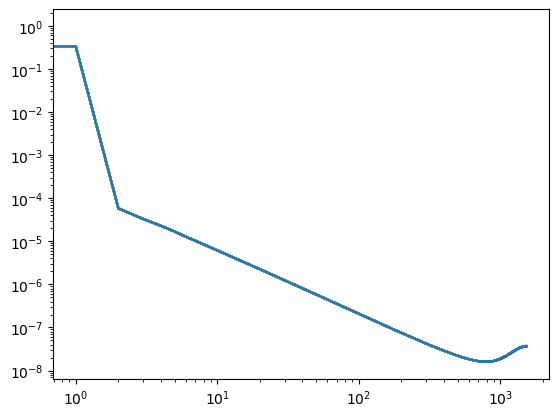

In [ ]:
# Generate a list from 55.0 to 85.0, with step be 0.5; include 85.0
freq_list = np.arange(55.0, 85.0+0.5, 0.5)
horn_wet = RhinoBeam(filepath='RHINO_beam/HornWet/')
horn_wet.get_beam_l()
beam_window = horn_wet.bl_list
# plot the bl_list as a list of plots of the bls

plt.plot(np.array(beam_window).T)
plt.yscale('log')
plt.xscale('log')

Dry ground beam chromaticity:

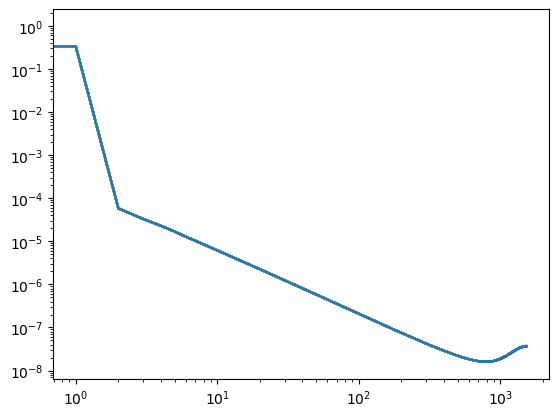

In [ ]:
horn_dry = RhinoBeam(filepath='RHINO_beam/HornDry/')
horn_dry.get_beam_l()
# plot the bl_list as a list of plots of the bls

plt.plot(np.array(horn_dry.bl_list).T)
plt.yscale('log')
plt.xscale('log')

Compare the wet ground and dry ground beams:

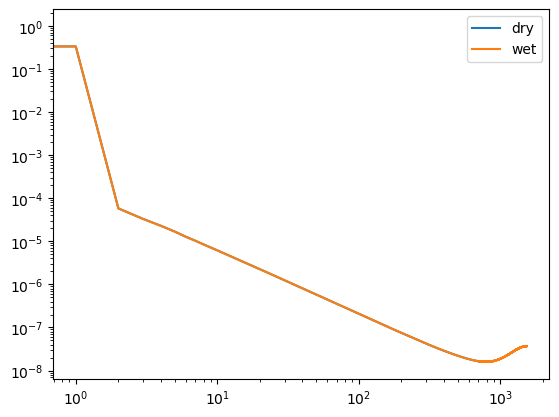

In [ ]:
plt.plot(horn_dry.bl_list[0], label='dry')
plt.plot(horn_wet.bl_list[0], label='wet')
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(6, 4))
ell = np.arange(len(horn_wet.bl_list[0]))
plt.plot(ell, horn_wet.bl_list[0], 'b-', lw=1.5)
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0, 500)  # Limit to reasonable ℓ range
plt.grid(True, which='both', alpha=0.4)
plt.xlabel(r'$\ell$', fontsize=13)
plt.ylabel(r'$B_\ell$', fontsize=13)
#plt.title("Beam transfer function", pad=10)
plt.tight_layout()
plt.savefig('beam_transfer_function.pdf')

plt.show()

### Generate beam convolved global diffuse sky model

In [9]:
Mel_model = SynchrotronExtrapolator()
mel_sky_RHINO_convolved = Mel_model.map(freq_list, beam_window)
GSM_sky_RHINO_convolved = GSM_maps(freq_list, beam_transfer=beam_window)
pivot_specidx_map=Mel_model.specidx_map


In [ ]:
# hp.mollview(Mel_model.specidx_map, 
#             cmap='plasma',
#             title='')
# plt.tight_layout()
# plt.savefig('spec_ind_map.pdf')

In [ ]:
# A boring plot: beam convolved sky..
# hp.mollview(GSM_sky_RHINO_convolved[:,0], norm='log')
# plt.show()

### Creat the spectral basis (and visualize it)

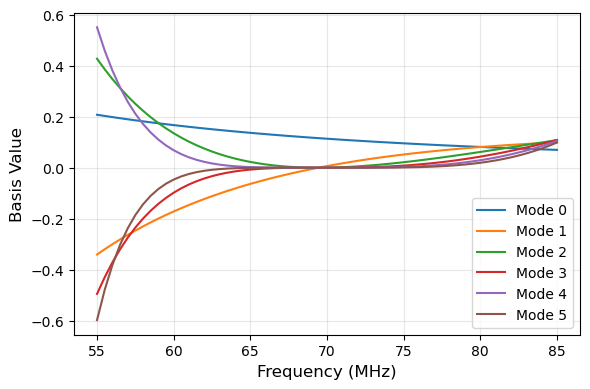

In [12]:

basis_gen = moment_basis(freqs=freq_list, n_moments=6)
design_matrix = basis_gen.basis(beta0=-2.5) 
plt.figure(figsize=(6, 4))
#linestys = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (1, 1))]
for i in range(design_matrix.shape[1]):
    plt.plot(freq_list, design_matrix[:, i], label=f'Mode {i}', 
            #linestyle=linestys[i]
            )
plt.xlabel('Frequency (MHz)', fontsize=12)
plt.ylabel('Basis Value', fontsize=12)
#plt.title('Design Matrix Columns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('derivative_spectra.pdf')  # Save the figure to a file
plt.show()

### Derive the reference frequency for moment expansion model

68.3739716558867


/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_45329/2967880354.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


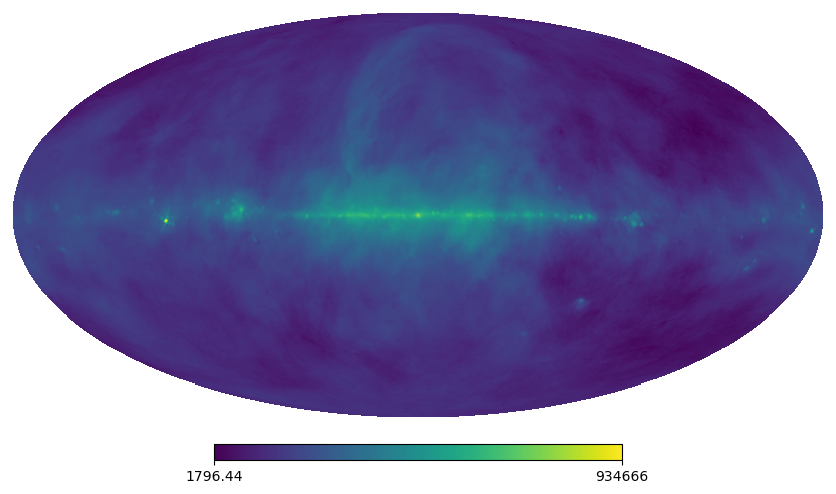

In [ ]:
nu_reference = np.exp((np.log(freq_list[0]) + np.log(freq_list[-1]))/2)
print(nu_reference)

# Visualize the intensity of the map at the pivot frequency
hp.mollview(Mel_model.map(nu_reference), 
            cmap='viridis',
            norm='log',
            title='')
plt.tight_layout()
plt.savefig('reference_map.pdf')

### Mel's model: visualise the power-law index ensemble for a given pixel (as an illustrating example of the ensemble)

In [ ]:
beam = hp.read_map('RHINO beam/HornWet/HornWet55.0.fits')
target_lon = 30  # Galactic longitude in degrees
target_lat = 45  # Galactic latitude in degrees
hist, bin_edges = Mel_model.beta_distribution(beam, n_bins=100, rotation=[target_lon, 90+target_lat, 0], show_hist=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

target_pixel_ind = hp.ang2pix(256, np.radians(target_lat), np.radians(target_lon))
pivot_specind = pivot_specidx_map[target_pixel_ind]
print(pivot_specind)

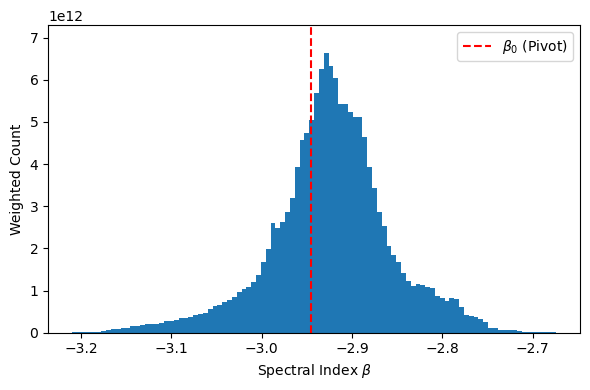

In [18]:
plt.figure(figsize=(6, 4))
plt.bar(bin_centers, hist, width=bin_edges[1]-bin_edges[0], align='center')
plt.vlines(x=pivot_specind, ymin=0, ymax=1.1*hist.max(), colors='red', linestyles='dashed', label=r'$\beta_0$ (Pivot)')
# ax = plt.gca()
# ax2 = ax.twiny()  # Create twin axis on top
# ax2.set_xlim(ax.get_xlim())  # Match main axis limits

# # Calculate Δβ labels for top axis
# ticks = ax.get_xticks()
# ax2.set_xticks(ticks)
# ax2.set_xticklabels([f"{x/delta_ln_nu_max+pivot_specind:+.2f}" for x in ticks])
# ax2.set_xlabel(f'Δβ from {pivot_specind:.2f}', fontsize=9)
plt.ylim(0, 1.1*hist.max())
plt.legend()
plt.xlabel(r'Spectral Index $\beta$')
plt.ylabel('Weighted Count')
# plt.title('Beam-weighted Spectral Index Distribution')
# plt.title(r'f($\beta$)')
plt.tight_layout()
plt.savefig('spectral_index_distribution.pdf')



### Understanding the accuracy of moment expansion...

In [ ]:
import math
# from ipywidgets import interact, IntSlider, Output  # Add explicit widget imports

def taylor_exp(x, n):
    """Taylor series approximation of e^x up to nth order"""
    return sum([x**k / math.factorial(k) for k in range(n+1)])

# Generate x values from -2 to 2
x = np.linspace(-2, 2, 200)
true_exp = np.exp(x)

delta_ln_nu_max = (np.log(freq_list[-1]) - np.log(freq_list[0])) / 2
xmaxs = (bin_centers - pivot_specind) * delta_ln_nu_max

# @interact(n=IntSlider(value=5, min=0, max=20, step=1, description='Order:'))
# def plot_comparison(n=5):
def plot_comparison(n_list=[3,4,5, 6], savepath=None):
    # Calculate approximation
    approx_list = [np.array([taylor_exp(xi, n) for xi in x]) for n in n_list]
    error_list = [np.abs(true_exp - approx) for approx in approx_list]
    line_style = ['--', '-.', ':', (0, (5, 5))]

    
    # Create plot
    plt.figure(figsize=(9, 9))
    # plt.figure(figsize=(10, 9))
    # gs = plt.GridSpec(4, 1, height_ratios=[3, 3, 2, 3], hspace=0.6) 
    # gs_top = gs[0:3].subgridspec(3, 1, hspace=0)
    gs_top = plt.GridSpec(3, 1, height_ratios=[3, 3, 2], hspace=0) 
    
    # Plot functions
    ax1 = plt.subplot(gs_top[0])
    plt.plot(x, true_exp, label=r'True $e^x$', color='gray', linewidth=3, alpha=0.5)
    for i in range(len(n_list)):
        plt.plot(x, approx_list[i], linestyle=line_style[i], label=f'Taylor (n={n_list[i]})')
    plt.ylabel('Value')
    #plt.xlabel('x')
    plt.setp(ax1.get_xticklabels(), visible=False)  
    plt.legend()
    
    # Plot error
    ax2 = plt.subplot(gs_top[1], sharex=ax1)
    for i in range(len(n_list)):
        plt.semilogy(x, error_list[i], linestyle=line_style[i], label=f'Error (n={n_list[i]})')
    # plt.semilogy(x, np.abs(true_exp - approx))
    plt.ylabel('Absolute Error')
    plt.setp(ax1.get_xticklabels(), visible=False)  # 隐藏x轴标
    #plt.xlabel('x')
    ax3 = plt.subplot(gs_top[2], sharex=ax1)
    plt.bar(xmaxs, hist, width=bin_edges[1]-bin_edges[0], align='center', color='gray', alpha=0.5)
    plt.yscale('log')
    plt.ylabel('Weight')
    plt.xlabel('x')


    # ax4 = plt.subplot(gs[3])
    # plt.bar(bin_centers, hist, width=bin_edges[1]-bin_edges[0], align='center')
    # plt.vlines(x=pivot_specind, ymin=0, ymax=1.1*hist.max(), colors='red', linestyles='dashed', label=r'$\beta_0$ (Pivot)')
    # # ax = plt.gca()
    # # ax2 = ax.twiny()  # Create twin axis on top
    # # ax2.set_xlim(ax.get_xlim())  # Match main axis limits
    
    # # # Calculate Δβ labels for top axis
    # # ticks = ax.get_xticks()
    # # ax2.set_xticks(ticks)
    # # ax2.set_xticklabels([f"{x/delta_ln_nu_max+pivot_specind:+.2f}" for x in ticks])
    # # ax2.set_xlabel(f'Δβ from {pivot_specind:.2f}', fontsize=9)
    # plt.ylim(0, 1.1*hist.max())
    # plt.legend()
    # plt.xlabel(r'Spectral Index $\beta$')
    # plt.ylabel('Weighted Count')
    # plt.title('Beam-weighted Spectral Index Distribution')
    
    # plt.subplots_adjust(top=0.93, bottom=0.12, 
    #                    hspace=0.6)  

    #plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()



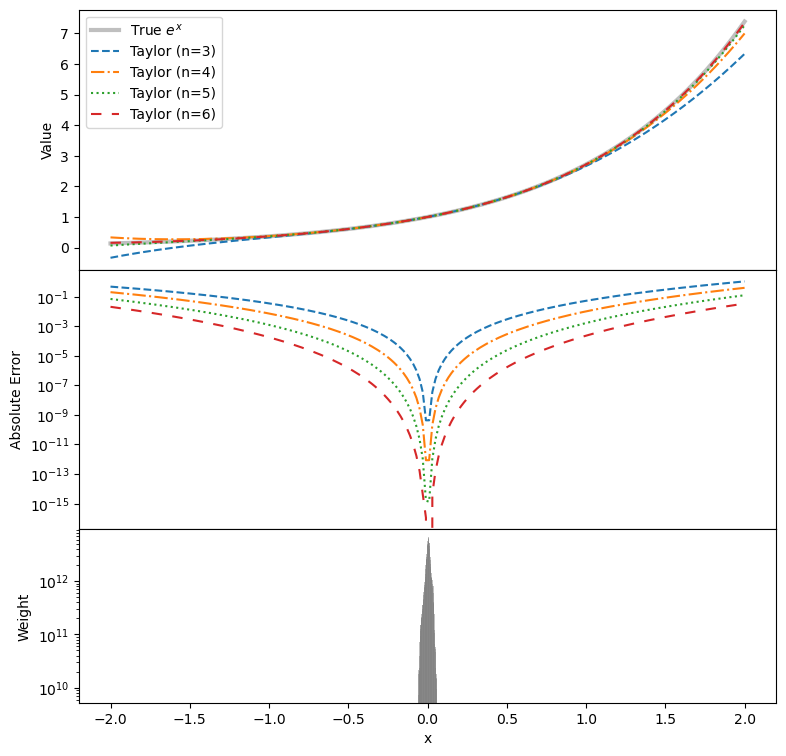

In [40]:
plot_comparison(savepath='expansion_plot.pdf')

## Sky Model fittings

### Fitting with three moments

In [27]:
Mel_moment_coeffs_maps_3, Mel_loss_map_3 = fit_entire_map(mel_sky_RHINO_convolved, pivot_specidx_map, freq_list, nu_ref=None, n_moments=3)
np.save('Mel_moment_maps_3.npy', Mel_moment_coeffs_maps_3)
np.save('Mel_loss_map_3.npy', Mel_loss_map_3)

In [28]:
GSM_moment_coeffs_maps_3, GSM_loss_map_3 = fit_entire_map(GSM_sky_RHINO_convolved, pivot_specidx_map, freq_list, nu_ref=None, n_moments=3)
np.save('GSM_moment_maps_3.npy', GSM_moment_coeffs_maps_3)
np.save('GSM_loss_map_3.npy', GSM_loss_map_3)

### With four moments

In [29]:
Mel_moment_coeffs_maps_4, Mel_loss_map_4 = fit_entire_map(mel_sky_RHINO_convolved, pivot_specidx_map, freq_list, nu_ref=None, n_moments=4)
np.save('Mel_moment_maps_4.npy', Mel_moment_coeffs_maps_4)
np.save('Mel_loss_map_4.npy', Mel_loss_map_4)


In [30]:
GSM_moment_coeffs_maps_4, GSM_loss_map_4 = fit_entire_map(GSM_sky_RHINO_convolved, pivot_specidx_map, freq_list, nu_ref=None, n_moments=4)
np.save('GSM_moment_maps_4.npy', GSM_moment_coeffs_maps_4)
np.save('GSM_loss_map_4.npy', GSM_loss_map_4)

### With five moments

In [31]:
Mel_moment_coeffs_maps_5, Mel_loss_map_5 = fit_entire_map(mel_sky_RHINO_convolved, pivot_specidx_map, freq_list, nu_ref=None, n_moments=5)
np.save('Mel_moment_maps_5.npy', Mel_moment_coeffs_maps_5)
np.save('Mel_loss_map_5.npy', Mel_loss_map_5)


In [32]:
GSM_moment_coeffs_maps_5, GSM_loss_map_5 = fit_entire_map(GSM_sky_RHINO_convolved, pivot_specidx_map, freq_list, nu_ref=None, n_moments=5)

np.save('GSM_moment_maps_5.npy', GSM_moment_coeffs_maps_5)
np.save('GSM_loss_map_5.npy', GSM_loss_map_5)

### With six moments

In [33]:
Mel_moment_coeffs_maps_6, Mel_loss_map_6 = fit_entire_map(mel_sky_RHINO_convolved, pivot_specidx_map, freq_list, nu_ref=None, n_moments=6)
np.save('Mel_moment_maps_6.npy', Mel_moment_coeffs_maps_6)
np.save('Mel_loss_map_6.npy', Mel_loss_map_6)

In [34]:
GSM_moment_coeffs_maps_6, GSM_loss_map_6 = fit_entire_map(GSM_sky_RHINO_convolved, pivot_specidx_map, freq_list, nu_ref=None, n_moments=6)
np.save('GSM_moment_maps_6.npy', GSM_moment_coeffs_maps_6)
np.save('GSM_loss_map_6.npy', GSM_loss_map_6)

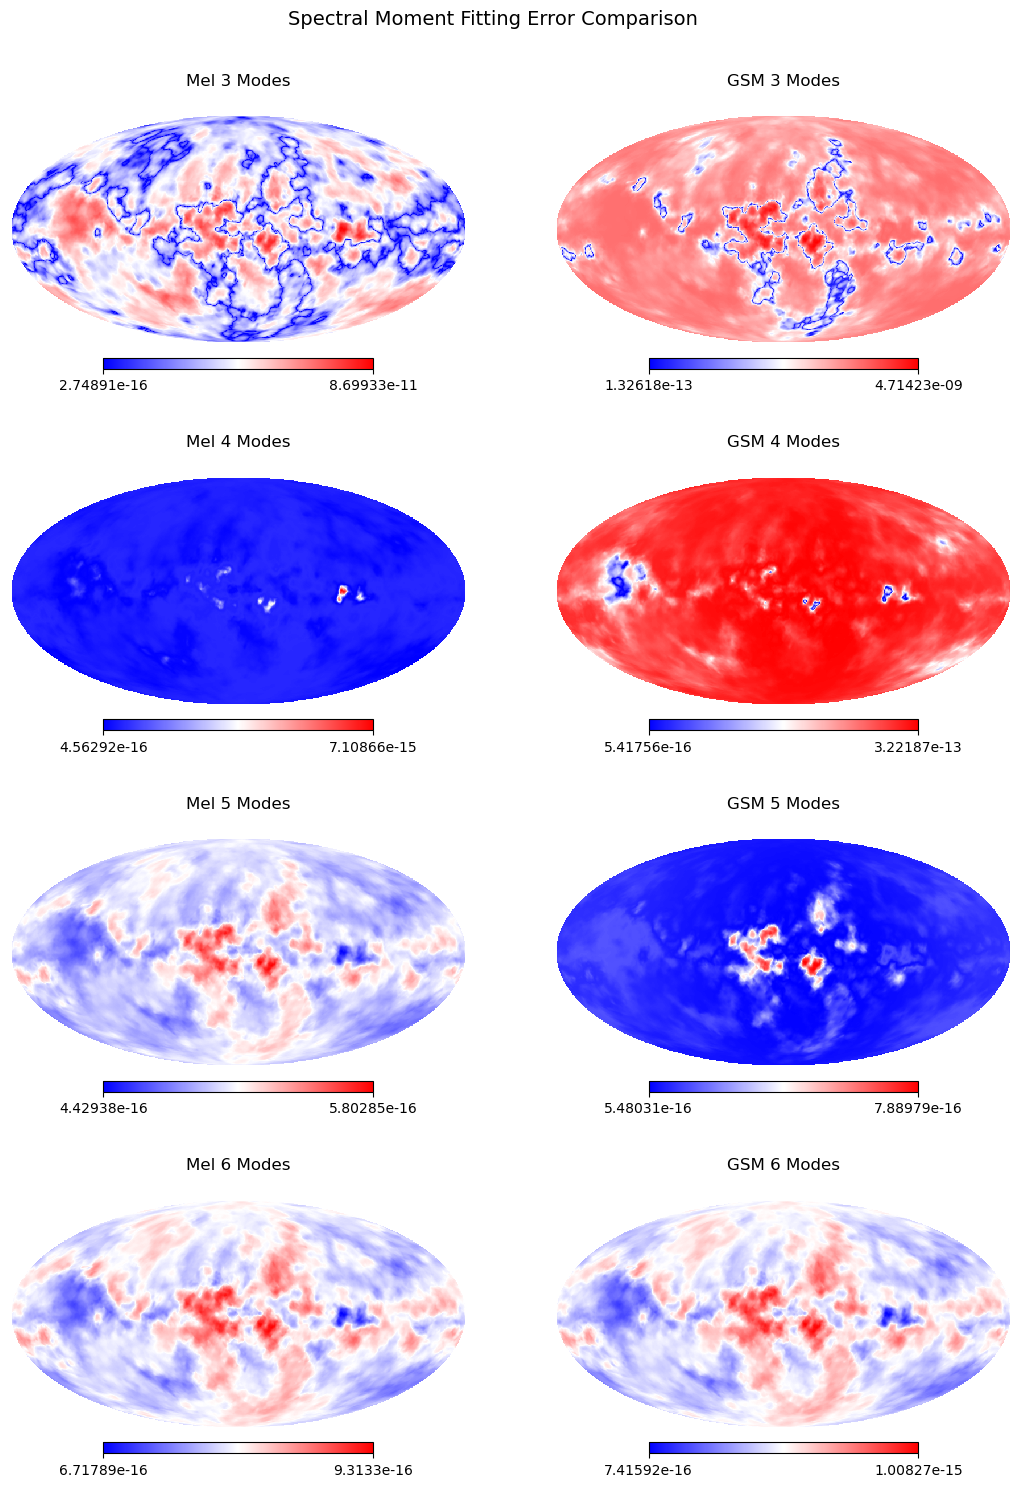

In [ ]:

# Generate a figure with 6 subplots, with the layout as 3 rows and 2 columns.
# The first row are healmaps of Mel_loss_map_3 and GSM_loss_map_3, with the same colorbar.
# The second row are healmaps of Mel_loss_map_4 and GSM_loss_map_4, with the same colorbar.
# The third row are healmaps of Mel_loss_map_5 and GSM_loss_map_5, with the same colorbar.

def plot_loss_comparison(savepath=None):
    plt.figure(figsize=(14, 18))
    
    maps = [
        (Mel_loss_map_3, GSM_loss_map_3, '3 Modes'),
        (Mel_loss_map_4, GSM_loss_map_4, '4 Modes'), 
        (Mel_loss_map_5, GSM_loss_map_5, '5 Modes'),
        (Mel_loss_map_6, GSM_loss_map_6, '6 Modes')
    ]
    titles = ['Mel', 'GSM', '']
    
    gs = plt.GridSpec(4, 2, width_ratios=[1, 1], height_ratios=[1,1,1, 1], wspace=0.01)
    
    for row in range(4):
        map1, map2, label = maps[row]
        
        vmin = min(np.nanpercentile(map1, 1), np.nanpercentile(map2, 1))
        vmax = max(np.nanpercentile(map1, 99), np.nanpercentile(map2, 99))
        
        cbar='bwr'
        ax1 = plt.subplot(gs[row, 0], projection='mollweide')
        im1 = hp.mollview(map1, title='', hold=True, 
                          #min=vmin, max=vmax, 
                          norm='log',
                          cmap=cbar)
        plt.text(0.5, 1.1, f'{titles[0]} {label}', 
                ha='center', va='bottom', transform=ax1.transAxes, fontsize=12)
        
        ax2 = plt.subplot(gs[row, 1], projection='mollweide')
        im2 = hp.mollview(map2, title='', hold=True, 
                          #min=vmin, max=vmax, 
                          norm='log',
                          cmap=cbar)
        plt.text(0.5, 1.1, f'{titles[1]} {label}', 
                ha='center', va='bottom', transform=ax2.transAxes, fontsize=12)
        
        # cax = plt.subplot(gs[row, 2])
        # plt.colorbar(im1['cmap'], cax=cax).set_label('Loss Value', fontsize=10)
    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.suptitle('Spectral Moment Fitting Error Comparison', y=0.93, fontsize=14)
    plt.show()

plot_loss_comparison(savepath='./loss_comparison.pdf')

### Visualise the moment maps

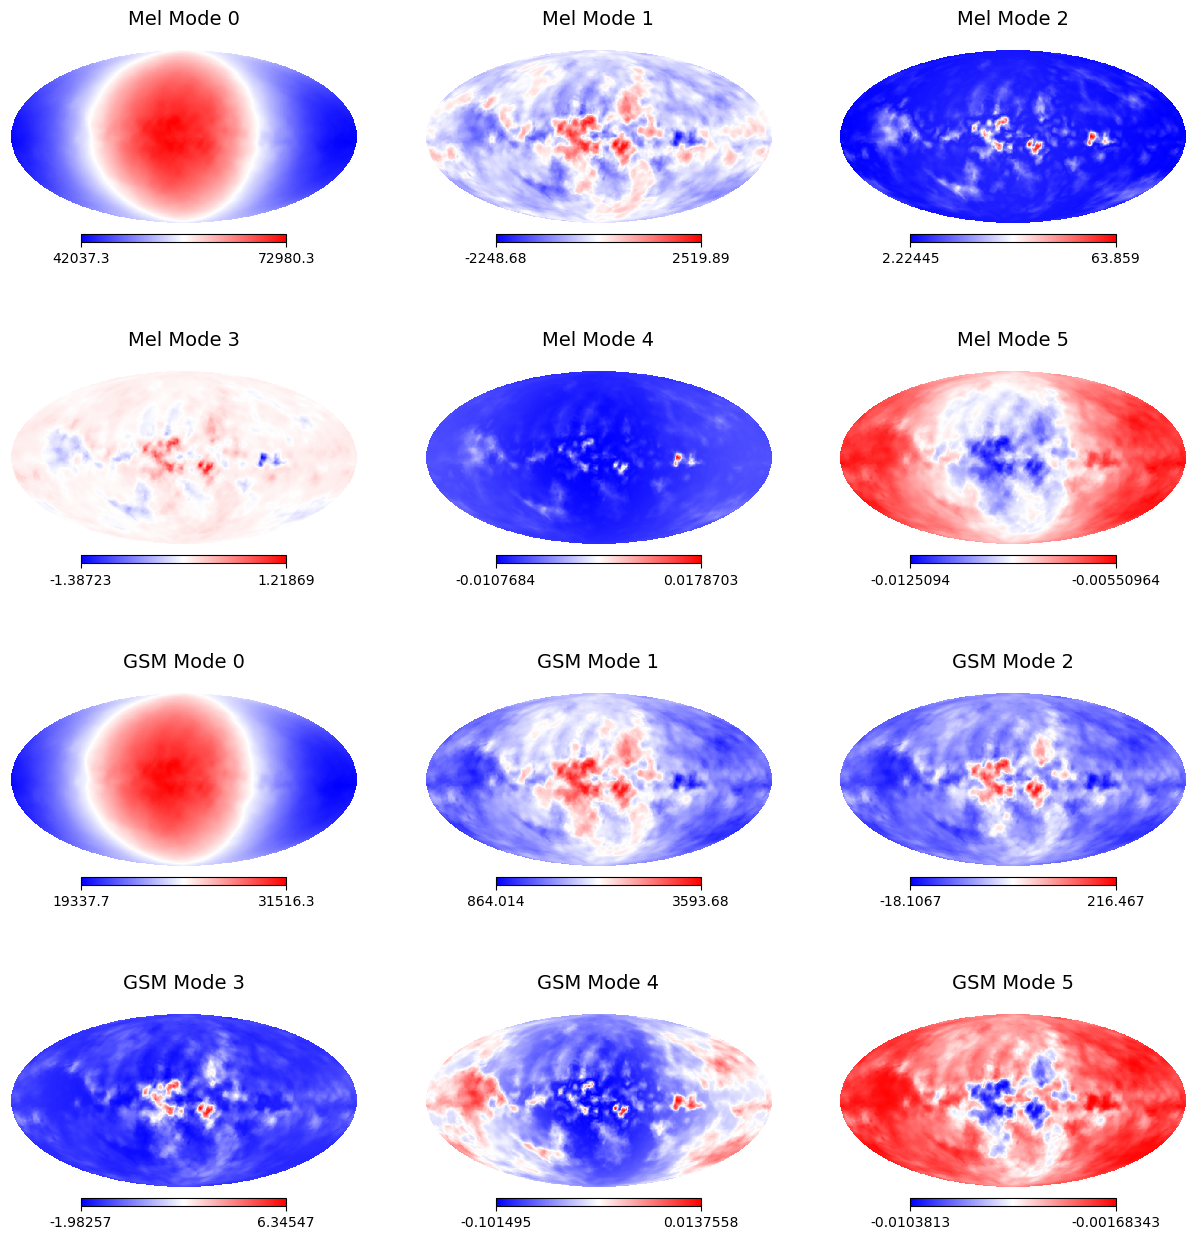

In [37]:

def plot_moment_maps(savepath=None):
    plt.figure(figsize=(16, 16))
    

    titles = [['Mel']*6, ['GSM']*6]
    
    gs = plt.GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1,1,1,1], wspace=0.01)
    
    for row in range(2):
        for col in range(3):
            ind=row*3+col
            map=Mel_moment_coeffs_maps_6[:,ind]
        
            if ind==0:
                # not using diverging colormap
                cbar='bwr'
            else:
                # using diverging colormap
                cbar='bwr'
            ax1 = plt.subplot(gs[row, col], projection='mollweide')
            im1 = hp.mollview(map, title='', hold=True, 
                            #min=vmin, max=vmax, 
                            #norm='log',
                            cmap=cbar)
            plt.text(0.5, 1.1, f'{titles[0][ind]} Mode {ind}', 
                    ha='center', va='bottom', transform=ax1.transAxes, fontsize=14)

    for row in range(2):
        for col in range(3):
            ind=row*3+col
            map=GSM_moment_coeffs_maps_6[:,ind]
        
            if ind==0:
                # not using diverging colormap
                cbar='bwr'
            else:
                # using diverging colormap
                cbar='bwr'
            ax1 = plt.subplot(gs[row+2, col], projection='mollweide')
            im1 = hp.mollview(map, title='', hold=True, 
                            #min=vmin, max=vmax, 
                            #norm='log',
                            cmap=cbar)
            plt.text(0.5, 1.1, f'{titles[1][ind]} Mode {ind}', 
                    ha='center', va='bottom', transform=ax1.transAxes, fontsize=14)

    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    #plt.suptitle('Spectral Moment Fitting Error Comparison', y=0.93, fontsize=14)
    plt.show()

plot_moment_maps()

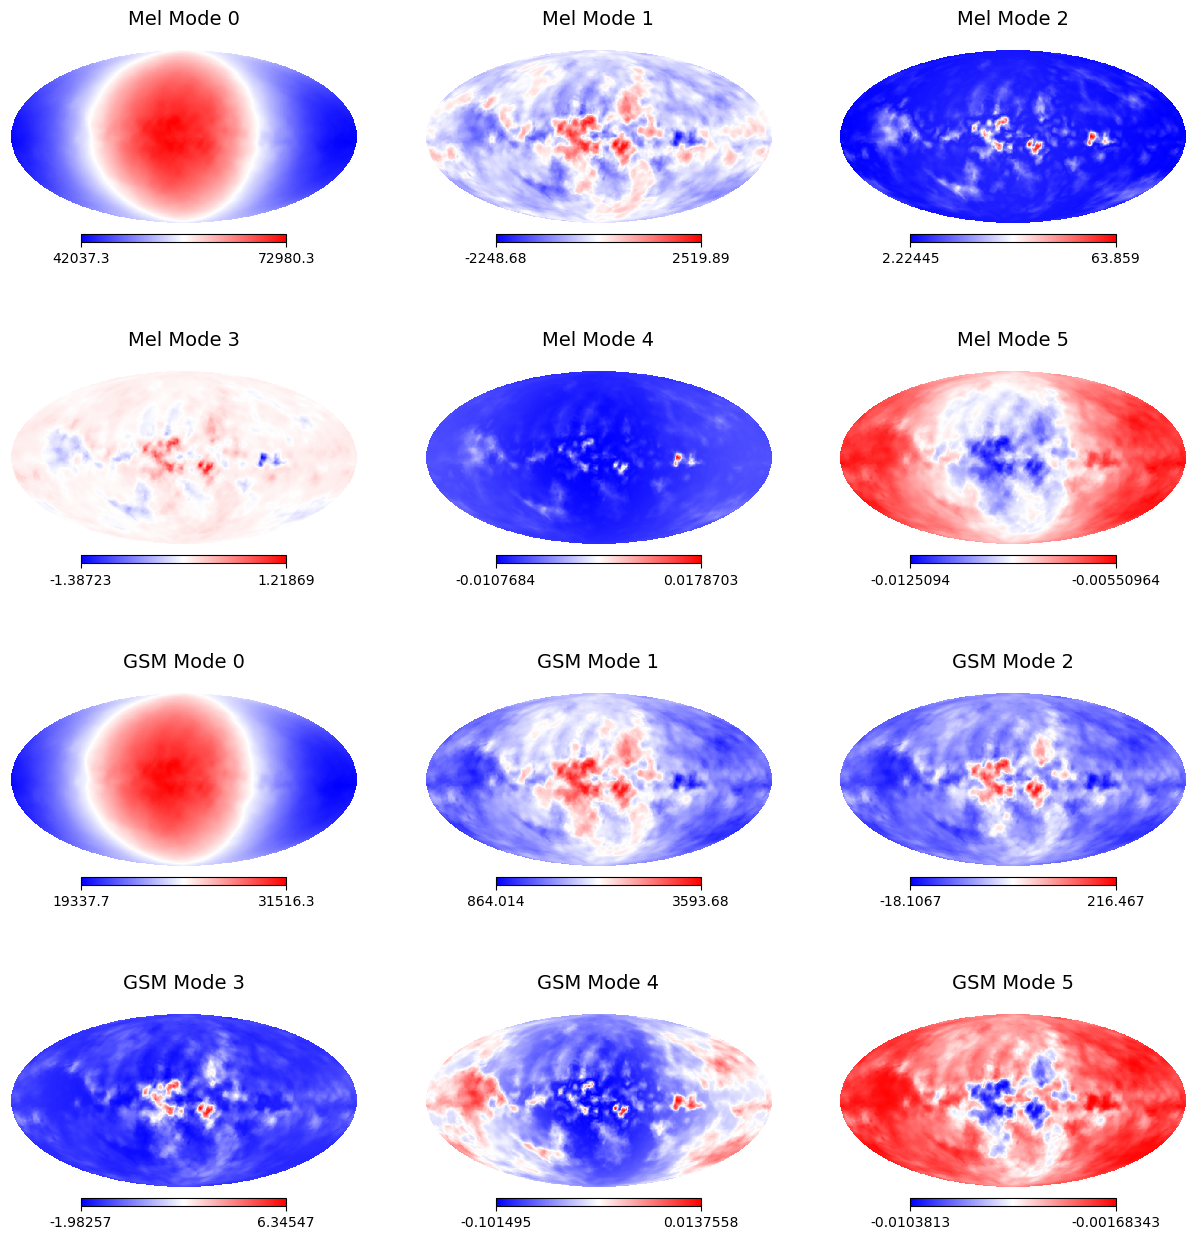

In [38]:
plot_moment_maps(savepath='moment_maps.pdf')